In [1]:
import torch
import matplotlib.pyplot as plt

In [ ]:
D = 3  # 2-sphere
K = 1  # 1-dimensional manifold
L = 5  # Uniform[-L, L] distribution
B = 4_096  # sampling batch size

In [3]:
source_dist = torch.distributions.uniform.Uniform(-L, L)
target_dist = torch.distributions.normal.Normal(0, 1)

Let's visualize the target distribution samples to see if they indeed are uniformally distributed on the surface of $S^{D - 1}$.

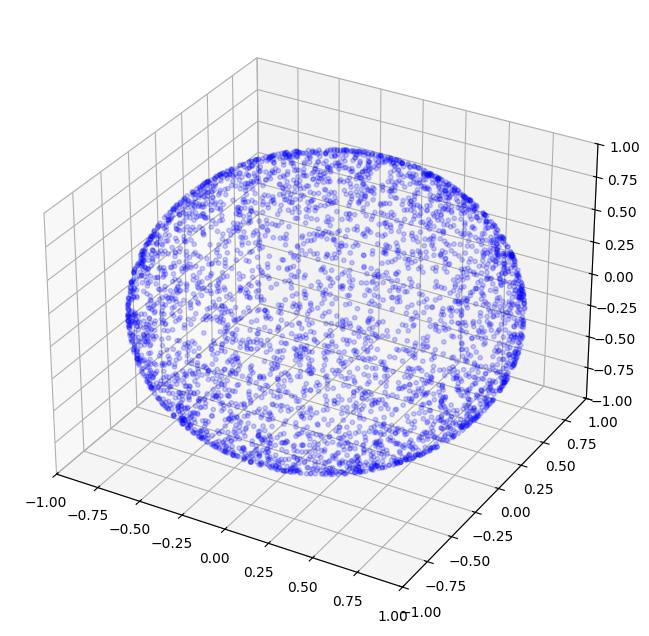

In [10]:
source_test = torch.nn.functional.normalize(target_dist.sample((B, D)), p=2).numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_test[:, 0], source_test[:, 1], source_test[:, 2], c='blue', alpha=0.2, s=10)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

## $\phi$ : Vanilla Generative Adversarial Framework

In [11]:
class Phi(torch.nn.Module):
    def __init__(self, omega=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(K, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, D)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self, omega=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(D, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, 1)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [13]:
LR = 1e-4
EPOCHS = 500
D_ITERATIONS = 10
G_ITERATIONS = 5

In [14]:
generator = Phi().to('cuda')
critic = Discriminator().to('cuda')

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LR)
criterion = torch.nn.BCEWithLogitsLoss()

In [15]:
source_samples = source_dist.sample((B, K)).to('cuda')
target_samples = torch.nn.functional.normalize(target_dist.sample((B, D)), p=2).to('cuda')

one_labels = torch.ones(B, 1).to('cuda')
zero_labels = torch.zeros(B, 1).to('cuda')

In [17]:
for epoch in range(EPOCHS):
    for _ in range(D_ITERATIONS):
        target_fwd = critic(target_samples)
        target_err = criterion(target_fwd, one_labels)
        
        phi = generator(source_samples)
        source_fwd = critic(phi)
        source_err = criterion(source_fwd, zero_labels)

        critic_loss = target_err + source_err
        critic_loss.backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()
    for _ in range(G_ITERATIONS):
        phi = generator(source_samples)
        source_fwd = critic(phi)
        gen_loss = criterion(source_fwd, one_labels)
        
        gen_loss.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

    print(f"Epoch {epoch + 1} | Critic Loss: {critic_loss.item():.5f} | Phi Loss: {gen_loss.item():.5f}")

Epoch 1 | Discriminator Loss: 1.27503 | Phi Loss: 0.81729
Epoch 2 | Discriminator Loss: 1.23269 | Phi Loss: 0.84404
Epoch 3 | Discriminator Loss: 1.18430 | Phi Loss: 0.88497
Epoch 4 | Discriminator Loss: 1.13256 | Phi Loss: 0.93018
Epoch 5 | Discriminator Loss: 1.08107 | Phi Loss: 0.97544
Epoch 6 | Discriminator Loss: 1.03328 | Phi Loss: 1.01593
Epoch 7 | Discriminator Loss: 0.99119 | Phi Loss: 1.04849
Epoch 8 | Discriminator Loss: 0.95454 | Phi Loss: 1.07317
Epoch 9 | Discriminator Loss: 0.92202 | Phi Loss: 1.09158
Epoch 10 | Discriminator Loss: 0.89271 | Phi Loss: 1.10476
Epoch 11 | Discriminator Loss: 0.86664 | Phi Loss: 1.11311
Epoch 12 | Discriminator Loss: 0.84342 | Phi Loss: 1.11760
Epoch 13 | Discriminator Loss: 0.82227 | Phi Loss: 1.11980
Epoch 14 | Discriminator Loss: 0.80239 | Phi Loss: 1.12107
Epoch 15 | Discriminator Loss: 0.78331 | Phi Loss: 1.12227
Epoch 16 | Discriminator Loss: 0.76478 | Phi Loss: 1.12371
Epoch 17 | Discriminator Loss: 0.74675 | Phi Loss: 1.12513
Epoch 

We see that a vanilla GAN for $\phi : \mathcal{U}[-L, L] \rightarrow \mathcal{U}(S^{d-1})$ makes errors, even for a trivial problem like $d = 3$.

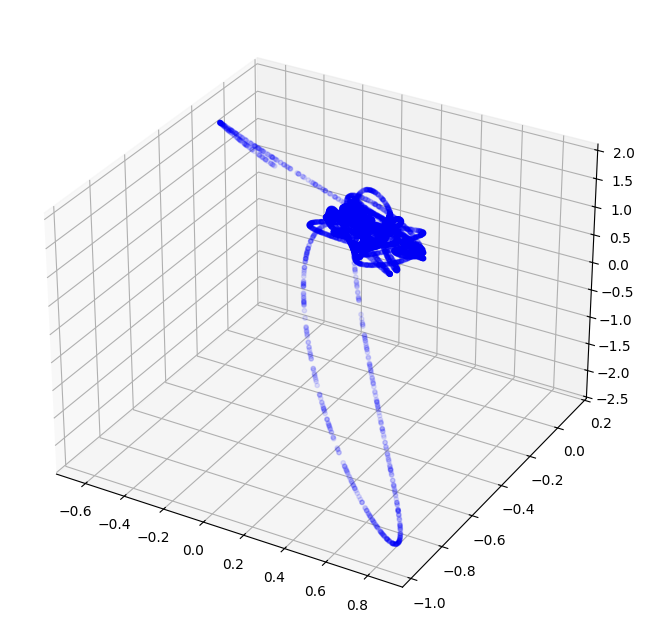

In [19]:
data = source_dist.sample((10_000, K)).to('cuda')
manifold = generator(data).cpu().detach()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold.numpy()[:, 0], manifold.numpy()[:, 1], manifold.numpy()[:, 2], c='blue', alpha=0.1, s=10)
plt.show()

In [20]:
torch.norm(manifold[0, :])

tensor(0.1830)

## $\phi$ : Wasserstein GAN